# Эксперимент
Хотим посмотреть, насколько эффектино можно предобучить ViT с помщью авторской функции потерь SplitMask на ооооочень маленькой наразмеченной выборке картинок (9469 штучек -- imagenette2-320).

Для этого проведём 3 эксперимента. Чтобы оценить качество предобученных, будем дообучать предобученный ViT на урезенный tiny-imagenet (10000 тренировочных картинок, 10000 валидационных, 200 классов).

Попробуем 3 варианта получения предобученных весов:
1. не будуем предобучать;
2. предобучим самодельныйм c помощью самодельного SplitMask К СТАТЬЕ НУЖНО ПУБЛИКОВТЬ КОД!!!
3. скачаем веса предобученные на ImageNet в supervised манере. 


In [ ]:
! pip install vit-pytorch
! pip install info-nce-pytorch

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/HSE/НИС/SplitMask/imagenette2-320.tgz .
! tar zxf imagenette2-320.tgz

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import repeat
from vit_pytorch.vit import Transformer
from torch.utils.data import Dataset, DataLoader
import numpy as np
import PIL
import torchvision.transforms as transforms
import os
import glob
from vit_pytorch import ViT
from torch.optim import Adam
import tqdm
from info_nce import InfoNCE 

IMAGE_SIZE = 256

In [ ]:
class MyDataset(Dataset):
    def __init__(self, transform, folder):
        super().__init__()
        self.transform = transform
        self.files = [y for x in os.walk(folder) for y in glob.glob(os.path.join(x[0], '*.JPEG'))]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        image = np.array(PIL.Image.open(self.files[index]))
        if len(image.shape) == 2:
            image = np.stack((image, image, image), axis=-1)
        image = self.transform(image)
        return image

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ]
)

In [ ]:
dataset_trn = MyDataset(transform, "/content/imagenette2-320/train")
dataset_val = MyDataset(transform, "/content/imagenette2-320/val")
print(len(dataset_trn))
print(len(dataset_val))

9469
3925


In [ ]:
class SplitMaskLoss(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.to_patch, self.patch_to_emb = encoder.to_patch_embedding[:2]
        pixel_values_per_patch = self.patch_to_emb.weight.shape[-1]

        # decoder parameters

        self.mask_token = nn.Parameter(torch.randn(encoder_dim))
        self.decoder = Transformer(dim = encoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = encoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, encoder_dim)
        self.to_pixels = nn.Linear(encoder_dim, pixel_values_per_patch)
         
        self.pooling = nn.AvgPool1d(64)
        self.infonceloss = InfoNCE()

    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions

        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = num_patches // 2
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices_1, masked_indices_2 = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens_1 = tokens[batch_range, masked_indices_2]
        tokens_2 = tokens[batch_range, masked_indices_1]

        # get the patches to be masked for the final reconstruction loss

        masked_patches_1 = patches[batch_range, masked_indices_1]
        masked_patches_2 = patches[batch_range, masked_indices_2]

        # attend with vision transformer

        encoded_tokens_1 = self.encoder.transformer(tokens_1)
        encoded_tokens_2 = self.encoder.transformer(tokens_2)

        decoder_tokens_1 = encoded_tokens_1
        decoder_tokens_2 = encoded_tokens_2

        # reapply decoder position embedding to unmasked tokens

        decoder_tokens_1 = decoder_tokens_1 + self.decoder_pos_emb(masked_indices_2)
        decoder_tokens_2 = decoder_tokens_2 + self.decoder_pos_emb(masked_indices_1)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens_1 = mask_tokens + self.decoder_pos_emb(masked_indices_1)
        mask_tokens_2 = mask_tokens + self.decoder_pos_emb(masked_indices_2)

        # concat the masked tokens to the decoder tokens and attend with decoder
        positive_key = torch.cat((decoder_tokens_1, decoder_tokens_2), dim=1)

        decoder_tokens_1 = torch.cat((mask_tokens_1, decoder_tokens_1), dim = 1)
        decoded_tokens_1 = self.decoder(decoder_tokens_1)
        decoder_tokens_2 = torch.cat((mask_tokens_2, decoder_tokens_2), dim = 1)
        decoded_tokens_2 = self.decoder(decoder_tokens_2)

        # splice out the mask tokens and project to pixel values

        mask_tokens_1 = decoded_tokens_1[:, :num_masked]
        pred_pixel_values_1 = self.to_pixels(mask_tokens_1)
        mask_tokens_2 = decoded_tokens_2[:, :num_masked]
        pred_pixel_values_2 = self.to_pixels(mask_tokens_2)

        query = torch.cat((mask_tokens_1, mask_tokens_2), dim=1)
        query = self.pooling(query.permute(0,2,1)).squeeze(2)
        positive_key = self.pooling(positive_key.permute(0,2,1)).squeeze(2)
        infonce_loss = self.infonceloss(query=query, positive_key=positive_key)

        # calculate reconstruction loss

        recon_loss = \
            F.mse_loss(pred_pixel_values_1, masked_patches_1) + \
            F.mse_loss(pred_pixel_values_2, masked_patches_2)
        return recon_loss + infonce_loss

In [ ]:
loader_trn = DataLoader(dataset = dataset_trn, batch_size = 32, shuffle=True, num_workers=2)
loader_val = DataLoader(dataset = dataset_val, batch_size = 32, shuffle=False, num_workers=2)

In [ ]:
device = "cuda"

In [ ]:
model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
).to(device)

split_mask_loss = SplitMaskLoss(
    encoder = model,
    decoder_depth = 6       # anywhere from 1 to 8
).to(device)

optimizer = Adam(split_mask_loss.parameters(), lr=5e-5)

In [ ]:
train_losses = []
num_epochs = 200
best_loss = None
best_ep = None


for epoch in range(1, num_epochs + 1):
    split_mask_loss.train()
    train_loss = 0.0
    for images in loader_trn:
        images = images.to(device)
        optimizer.zero_grad()
        loss = split_mask_loss(images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss/len(loader_trn.sampler)

    split_mask_loss.eval()
    with torch.no_grad():
        valid_loss = 0.0
        for images in loader_val:
            images = images.to(device)
            loss = split_mask_loss(images)
            valid_loss += loss.item()
        valid_loss = valid_loss/max(len(loader_val.sampler),1)

        if best_loss is None or valid_loss < best_loss:
            if best_ep is not None:
                os.remove(
                    '/content/drive/MyDrive/HSE/НИС/SplitMask/pretrained_net_' +
                    str(best_ep) + '.pt'
                )
            best_loss = valid_loss
            best_ep = epoch
            torch.save(
                model.state_dict(),
                '/content/drive/MyDrive/HSE/НИС/SplitMask/pretrained_net_' +
                str(best_ep) + '.pt'
            )
        print('ep:', epoch, 'train:', train_loss, 'val:', valid_loss)

ep: 1 train: 0.09099033606796433 val: 0.061005992099737665
ep: 2 train: 0.0510996405004964 val: 0.047834649085998535
ep: 3 train: 0.041158158142874615 val: 0.04107732753085483
ep: 4 train: 0.03725250072722979 val: 0.03822795880068639
ep: 5 train: 0.03546167026793318 val: 0.03648587680925989
ep: 6 train: 0.03413636595788155 val: 0.03524326716259027
ep: 7 train: 0.03313623186980221 val: 0.03419857406312493
ep: 8 train: 0.032284202810098736 val: 0.03341746225478543
ep: 9 train: 0.031745933192196006 val: 0.03290457985203737
ep: 10 train: 0.03125794829732073 val: 0.03222395816426368
ep: 11 train: 0.03081462229427459 val: 0.03199852042896732
ep: 12 train: 0.030577289163027686 val: 0.03176347137256792
ep: 13 train: 0.030272034962233425 val: 0.031312271303432004
ep: 14 train: 0.029943956771336534 val: 0.031117669913419493
ep: 15 train: 0.029707990977816755 val: 0.03082451811261997
ep: 16 train: 0.029423786759414296 val: 0.030510369820199956
ep: 17 train: 0.029210166526276355 val: 0.03026453703

KeyboardInterrupt: ignored

In [ ]:
! cp /content/drive/MyDrive/HSE/НИС/SplitMask/tiny-imagenet-200.zip .
! rm -r tiny-imagenet-200
! unzip -q tiny-imagenet-200.zip

rm: cannot remove 'tiny-imagenet-200': No such file or directory


In [ ]:
import random
random.seed(42)

ids = dict()
with open("/content/tiny-imagenet-200/wnids.txt", "r") as f:
    i = 0
    for line in f:
        ids[line.strip()] = i
        i += 1

class TinyImagenetDataset(Dataset):
    def __init__(self, transform, train_eval):
        super().__init__()
        self.transform = transform
        self.labels = []
        if train_eval == "train":
            self.files = [y for x in os.walk("/content/tiny-imagenet-200/train") for y in glob.glob(os.path.join(x[0], '*.JPEG'))]
            random.shuffle(self.files)
            self.files = self.files[:10000]
            for filename in self.files:
                id = filename.split("_")[0].split("/")[-1]
                self.labels.append(ids[id])
        else:
            self.files = [y for x in os.walk("/content/tiny-imagenet-200/val") for y in glob.glob(os.path.join(x[0], '*.JPEG'))]
            d = {}
            with open("/content/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
                for line in f:
                    part = line.split("\t")
                    d[part[0]] = ids[part[1]]
            for filename in self.files:
                self.labels.append(d[filename.split("/")[-1]])
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        image = np.array(PIL.Image.open(self.files[index]))
        if len(image.shape) == 2:
            image = np.stack((image, image, image), axis=-1)
        image = self.transform(image)
        return image, self.labels[index]

In [ ]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, hue=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(15),
        transforms.RandomPerspective(),
    ]
)

In [ ]:
tiny_image_trn = TinyImagenetDataset(transform_train, "train")
print(len(tiny_image_trn))
print(tiny_image_trn.labels)
print(max(tiny_image_trn.labels))
tiny_image_val = TinyImagenetDataset(transform, "valid")
print(len(tiny_image_val))
print(max(tiny_image_val.labels))
tiny_trn_loader = DataLoader(dataset = tiny_image_trn, batch_size = 32, shuffle=True, num_workers=2)
tiny_val_loader = DataLoader(dataset = tiny_image_val, batch_size = 32, shuffle=False, num_workers=2)

10000
[127, 138, 56, 17, 116, 170, 121, 30, 11, 160, 130, 73, 177, 38, 146, 190, 192, 191, 130, 178, 65, 157, 46, 175, 121, 12, 148, 28, 53, 2, 168, 106, 34, 127, 26, 151, 170, 0, 53, 136, 8, 54, 7, 51, 12, 4, 5, 8, 11, 85, 4, 49, 16, 27, 107, 42, 181, 173, 196, 176, 27, 95, 141, 172, 97, 109, 115, 124, 108, 139, 152, 23, 93, 147, 5, 168, 35, 190, 43, 81, 177, 77, 165, 27, 119, 1, 31, 156, 188, 140, 22, 32, 38, 77, 35, 38, 146, 13, 139, 164, 79, 124, 48, 196, 169, 24, 183, 14, 118, 56, 143, 174, 48, 166, 139, 183, 123, 59, 167, 7, 11, 99, 146, 115, 23, 5, 68, 163, 76, 93, 187, 107, 187, 61, 144, 88, 81, 75, 44, 8, 79, 196, 69, 42, 118, 19, 51, 195, 99, 125, 109, 180, 70, 61, 98, 88, 47, 69, 15, 115, 168, 139, 138, 3, 197, 162, 184, 3, 150, 32, 157, 33, 171, 82, 171, 188, 149, 85, 48, 48, 184, 85, 166, 146, 171, 170, 142, 48, 177, 167, 118, 79, 38, 88, 94, 111, 157, 54, 176, 146, 140, 2, 127, 28, 110, 114, 152, 171, 141, 21, 67, 190, 25, 106, 42, 135, 184, 184, 35, 145, 10, 41, 16, 70, 

In [ ]:
#model = ViT(
#    image_size = 256,
#    patch_size = 32,
#    num_classes = 1000,
#    dim = 1024,
#    depth = 6,
#    heads = 8,
#    mlp_dim = 2048
#).to(device)

! pip install timm
import timm
IMAGE_SIZE = 224
model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
num_epochs = 50

train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for data, target in tiny_trn_loader:
        data = data.to(device)
        target = target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        output = model(data)[:200]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(tiny_trn_loader.sampler)
    print('ep:', epoch, 'train:', train_loss, end=' ')

    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        accuracy = 0
        for data, target in tiny_val_loader:
            data = data.to(device)
            target = target.to(device, dtype=torch.long)
            output = model(data)[:200]
            accuracy += (output.cpu().detach().numpy().argmax(axis=1) == target.cpu().numpy()).sum()
            loss = criterion(output, target)
            valid_loss += loss.item()
        valid_loss = valid_loss/max(len(tiny_val_loader.sampler),1)
        accuracy /= max(1, len(tiny_val_loader.sampler))
        print('val:', valid_loss, 'acc:', accuracy)

ep: 1 train: 0.1675598418712616 val: 0.1502747341632843 acc: 0.0571
ep: 2 train: 0.10455411123037338 val: 0.05833435016274452 acc: 0.5646
ep: 3 train: 0.03940072529911995 val: 0.0412668873667717 acc: 0.6821
ep: 4 train: 0.018402844884991647 val: 0.03882719139754772 acc: 0.6996
ep: 5 train: 0.009382755890488625 val: 0.039702597412467004 acc: 0.7112
ep: 6 train: 0.0060621940225362774 val: 0.04191860699057579 acc: 0.6998
ep: 7 train: 0.004891978501155973 val: 0.04614770849943161 acc: 0.6834
ep: 8 train: 0.004334783929865808 val: 0.04477366220057011 acc: 0.6903
ep: 9 train: 0.003772400244604796 val: 0.04679219331741333 acc: 0.6808
ep: 10 train: 0.004077007805788889 val: 0.04833102448582649 acc: 0.6791
ep: 11 train: 0.00354065324193798 val: 0.054306419932842256 acc: 0.6434
ep: 12 train: 0.0034238398947753013 val: 0.05011654067337513 acc: 0.6674
ep: 13 train: 0.003088908569747582 val: 0.05051116898953915 acc: 0.6756
ep: 14 train: 0.002668877504952252 val: 0.05551051068305969 acc: 0.6481
ep: 

## Результат эксперимента
| Откуда веса | Случайная инициализация | SplitMask (9,469) | Supervised (1,281,167) |
| --- | --- | --- | --- |
| Accuracy | 0.12 | 0.18 | 0.71 |

## Чуть более подробно

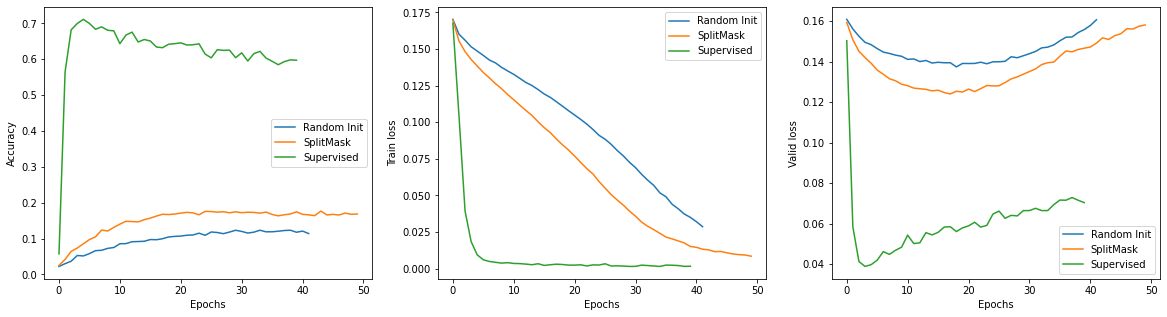

In [ ]:
random_init_acc = []
supervised_acc = []
unsupervised_acc = []

random_init_trn = []
supervised_trn = []
unsupervised_trn = []

random_init_val = []
supervised_val = []
unsupervised_val = []

with open("Random.txt", 'r') as f:
    for line in f:
        random_init_acc.append(float(line.split(' ')[7]))
        random_init_trn.append(float(line.split(' ')[3]))
        random_init_val.append(float(line.split(' ')[5]))

with open("50.txt", 'r') as f:
    for line in f:
        unsupervised_acc.append(float(line.split(' ')[7]))
        unsupervised_trn.append(float(line.split(' ')[3]))
        unsupervised_val.append(float(line.split(' ')[5]))

with open("Supervised.txt", 'r') as f:
    for line in f:
        supervised_acc.append(float(line.split(' ')[7]))
        supervised_trn.append(float(line.split(' ')[3]))
        supervised_val.append(float(line.split(' ')[5]))


import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(20, 5)

ax1.plot(random_init_acc, label='Random Init')
ax1.plot(unsupervised_acc, label='SplitMask')
ax1.plot(supervised_acc, label='Supervised')
ax1.set(xlabel="Epochs", ylabel="Accuracy")
ax1.legend()

ax2.plot(random_init_trn, label='Random Init')
ax2.plot(unsupervised_trn, label='SplitMask')
ax2.plot(supervised_trn, label='Supervised')
ax2.set(xlabel="Epochs", ylabel="Train loss")
ax2.legend()

ax3.plot(random_init_val, label='Random Init')
ax3.plot(unsupervised_val, label='SplitMask')
ax3.plot(supervised_val, label='Supervised')
ax3.set(xlabel="Epochs", ylabel="Valid loss")
ax3.legend()